In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
from gui.output_utils import *

def get_exp_ids_for_varying_k(corpus='amazon_grouped-tagged'):
    # curve when varying k
    query_dict = {'expansions__allow_overlap': 0,
                  'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
                 'document_features_ev': 'AN+NN',
                 'document_features_tr': 'J+N+AN+NN',
                 'expansions__k__in': [1, 3, 5, 10, 20, 30, 40, 50, 75, 100],
                 'labelled': 'amazon_grouped-tagged',
                 'expansions__neighbour_strategy': 'linear',
                 'expansions__noise': 0.0,
                 'expansions__use_random_neighbours': 0,
                 'expansions__use_similarity': 0,
                'expansions__vectors__composer__in': ['Add', 'Mult', 'Left', 'Right'], # , todo Verb???
                'expansions__vectors__algorithm': 'word2vec',
                 'expansions__vectors__dimensionality': 100,
                 'expansions__vectors__rep': 0,
                 'expansions__vectors__unlabelled': 'wiki',
                 'expansions__vectors__unlabelled_percentage': 100,                 
}
    return Experiment.objects.filter(**query_dict)#.values_list('id', flat=True)

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


ids are [34, 35, 36, 37, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]
62
folds has 20000 values
Composer has 20000 values
Accuracy has 20000 values
k has 20000 values


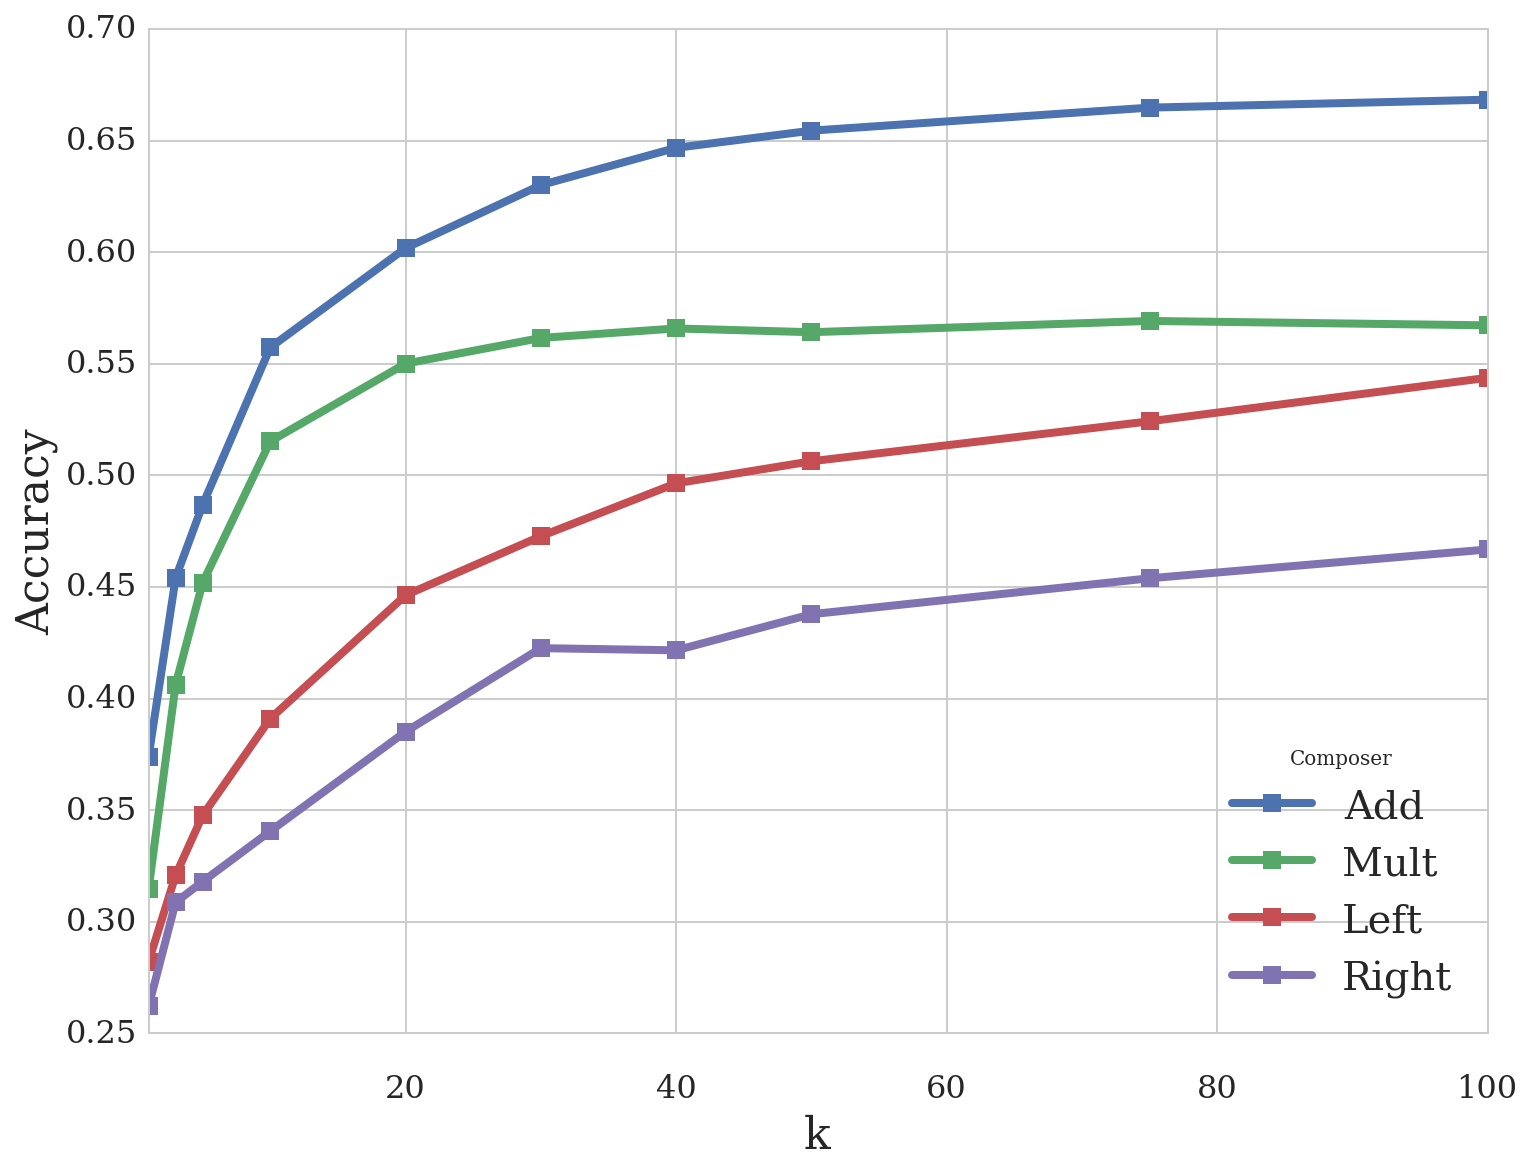

In [3]:
experiments = get_exp_ids_for_varying_k()
ids = [e.id for e in experiments if e.expansions.entries_of is None]
print('ids are', ids)
print(ids[19])

df = dataframe_from_exp_ids(ids, {'k':'expansions__k', 
                                  'Composer':'expansions__vectors__composer'}).convert_objects(convert_numeric=True)
sns.tsplot(time='k', value='Accuracy', data=df, 
           condition='Composer', unit='folds', 
#            err_style='unit_points',
           marker='s', linewidth=4);
plt.savefig('plot-w2v_effect-of-k.pdf', format='pdf', dpi=300)

# Analysis
I was initially fetching `1.5 * n_neighbours` from the KD tree, and then filtering those that overlap lexically. This resulted in many replacements not having as many neighbours as requested. The curves above would increase steadily until `k=100`:

<img src="img/effect-of-k-v1.png" width="40%"> 

When I'm fetching `3 * n_neighbours`, we still have many cases where there aren't enough non-overlapping replacements:

<img src="img/effect-of-k-v2.png" width="40%">

 - performance is a little bit higher
 - Add/Mult reaching a plateau already. If I increase the multiplier further we should start to see a decrease.
 - Add/Multi plateau, while L/M still increasing. Hypothesis: Add & Mult have 
 
 This suggests we have not yet gone through all the good neighbours, but we are starting to get there for Add/Mult.


Qualitatively, here are some neighbours from `w2v wiki-100%, Right composer`:
 - `vw touareg` --> `1. cabrio, 2. comp cabrio ... 99. volkswagen 100. early volkswagen` 
 - `lasting wiper` --> `1. new windshield, 2. alero windshield ... 99. motorcraft dample 100. rubber damper` 
 - `oldest grandchild` --> `1. younger sibling, 2. youngest sibling ... 99. secure daughter 100. cavalier daughter` 
 
`Right` is very productive and decent neighbours keep coming up, because for every neighbour of the head (e.g. `vw ---> volkswagen`) it can find a ton of modifiers to go with it.

The same thing with `Add` composition looks like this:

 - `vw touareg` --> `1. volkswagen lh, 2. volkswagen eo 3. cadillac ... 99. lumina sedan 100. mercedes-benz s-class` 
 - `lasting wiper` --> `1. great strut, 2. great windscreen ... 99. strong grip 100. strong strap` 
 - `oldest grandchild` --> `1. hidden sibling, 2. twin sister ... 99. twin baby 100. harriet` 
 
 It seems like `Add` is quicker to jump to other areas of the space because of the influence of the second word, so it runs out of good neigh faster. To stay in the same area of the space, the second word would need to have a near-zero vector, which is not common. That's why you get more diverse neighbours with Add.